In [27]:
from util import get_num_lines, get_vocab, embed_sequence, get_word2idx_idx2word, get_embedding_matrix
from util import TextDatasetWithGloveElmoSuffix as TextDataset
from util import evaluate
from model import RNNSequenceClassifier

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import csv
import h5py
# import matplotlib
# matplotlib.use('Agg')  # to avoid the error: _tkinter.TclError: no display name and no $DISPLAY environment variable
# matplotlib.use('tkagg') # to display the graph on remote server
import matplotlib.pyplot as plt

print("PyTorch version:")
print(torch.__version__)
print("GPU Detected:")
print(torch.cuda.is_available())
using_GPU = True

PyTorch version:
0.4.1.post2
GPU Detected:
True


In [2]:
agg_words = []

with open('../twitter_data/bad_word_ranking.txt') as f:
    lines = f.readlines()
    for line in lines:
        agg_words.append(line.replace('\n',''))
print(agg_words)
print('numebr of aggresive words: ', len(agg_words))

['bitch', 'bitches', 'hoes', 'pussy', 'hoe', 'fuck', 'shit', 'nigga', 'trash', 'niggas', 'fucking', 'dick', 'niggah', 'dumb', 'retarded', 'cunt', 'nigger', 'fag', 'fucked', 'nicca', 'ho', 'niccas', 'nig', 'retard', 'stfu', 'pussies', 'nigguh', 'faggots', 'brownies', 'niggers', 'redneck', 'dyke', 'fags', 'jihadi', 'chick', 'coon', 'tranny', 'negro', 'slut', 'cunts', 'brownie', 'jihadis', 'whore', 'niggahs', 'retards', 'chicks', 'balls', 'cock', 'nips', 'coons', 'asshole', 'nip', 'dumbass', 'ass', 'assholes', 'niglet', 'motherfucker', 'bastard', 'faggot', 'fuckin', 'dickhole']
numebr of aggresive words:  61


In [3]:
# with open('../aggression_dataset/aggression_annotations.tsv') as f:
#     lines = csv.reader(f, delimiter='\t')
#     next(lines, None)  # skip the headers
#     for line in lines:
#         rev_id = line[0]
#         # worker_id = line[1]
#         aggression_label = int(float(line[2]))
#         # aggression_score = float(line[3])
#         id2label[rev_id] = aggression_label 

# """
# 1. Data pre-processing
# """
# '''
# 1.1 
# get rev_id --> label as a dictionary:
#     rev_id: string to indicate the id of the comment
#     label: int 1 or 0
# '''
# id2label = {}
# with open('../aggression_dataset/aggression_annotations.tsv') as f:
#     lines = csv.reader(f, delimiter='\t')
#     next(lines, None)  # skip the headers
#     for line in lines:
#         rev_id = line[0]
#         # worker_id = line[1]
#         aggression_label = int(float(line[2]))
#         # aggression_score = float(line[3])
#         id2label[rev_id] = aggression_label                 
# '''
# 1.2 
# get raw dataset as three list with given train/dev/test split:
#   Each element is a triple:
#     comment: the text needed to be classified (removed NEWLINE_TOKEN)
#     rev_id: string
#     label: int 1 or 0
# '''


# raw_train = []
# raw_dev = []
# raw_test = []
# with open('../aggression_dataset/aggression_annotated_comments.tsv') as f:
#     lines = csv.reader(f, delimiter='\t')
#     next(lines, None)  # skip the headers
#     for line in lines:
#         rev_id = line[0]
#         # lowercse 
#         comment = line[1].replace('NEWLINE_TOKEN', '').lower()
#         split = line[6]
#         sen_len = len(comment.split())
#         if  sen_len != 0 and sen_len < 10000:  # filter for length
#             if split == 'train':
#                 raw_train.append([comment, rev_id, id2label[rev_id]])
#             elif split == 'dev':
#                 raw_dev.append([comment,rev_id,  id2label[rev_id]])
#             else:
#                 raw_test.append([comment, rev_id, id2label[rev_id]])     
            
# # datset split without limit on sen_len: train, dev, test:  69526=12875+56648       23160       23178
# # with limit on sen_len <= 50: 44227=8710+35517    14663=939+11724      14493=2828+11665
# # with limit on sen_len <= 100: 57664=10868+46796          19186          19154



"""
1. Data pre-processing
"""
'''
1.1 
get rev_id --> label as a dictionary:
    rev_id: string to indicate the id of the comment
    label: int 1 or 0
'''
# no need for this step for twitter data
# id2label = {}
# with open('../aggression_dataset/aggression_annotations.tsv') as f:
#     lines = csv.reader(f, delimiter='\t')
#     next(lines, None)  # skip the headers
#     for line in lines:
#         rev_id = line[0]
#         # worker_id = line[1]
#         aggression_label = int(float(line[2]))
#         # aggression_score = float(line[3])
#         id2label[rev_id] = aggression_label                 
'''
1.2 
get raw dataset as three list with given train/dev/test split:
  Each element is a triple:
    comment: the text needed to be classified (removed NEWLINE_TOKEN)
    second element?
    label: int 1 or 0
'''


raw_train = []
raw_dev = []
raw_test = []
with open('../twitter_data/tweet_train.csv') as f:
    lines = csv.reader(f)
    for line in lines:
        sentence = line[0]
        # lowercse 
        label = int(line[1])
        raw_train.append([sentence, None, label])    
        
with open('../twitter_data/tweet_dev.csv') as f:
    lines = csv.reader(f)
    for line in lines:
        sentence = line[0]
        # lowercse 
        label = int(line[1])
        raw_dev.append([sentence, None, label])  

with open('../twitter_data/tweet_test.csv') as f:
    lines = csv.reader(f)
    for line in lines:
        sentence = line[0]
        # lowercse 
        label = int(line[1])
        raw_test.append([sentence, None, label])  
            
print(len(raw_train), len(raw_dev), len(raw_test))

19586 2447 2449


In [4]:
"""
2. Data preparation
"""
'''
2. 1
get vocabulary and glove embeddings in raw dataset 
'''
# vocab is a set of words
vocab = get_vocab(raw_train + raw_dev + raw_test)
# two dictionaries. <PAD>: 0, <UNK>: 1
word2idx, idx2word = get_word2idx_idx2word(vocab)
# glove_embeddings a nn.Embeddings
glove_embeddings = get_embedding_matrix(word2idx, idx2word, normalization=False)
# elmo_embeddings
# elmos_train_vua = h5py.File('../elmo/VUA_train.hdf5', 'r')
# elmos_val_vua = h5py.File('../elmo/VUA_val.hdf5', 'r')

# suffix_embeddings: number of suffix tag is 2, and the suffix embedding dimension is 50
suffix_embeddings = nn.Embedding(2, 50)

vocab size:  24904


100%|██████████| 2196017/2196017 [00:36<00:00, 60800.66it/s]


Number of pre-trained word vectors loaded:  22244
Embeddings mean:  -0.0041196770034730434
Embeddings stdev:  0.3818887770175934


In [5]:
# dataset study

# raw_train_pos = []  # 8710
# raw_train_neg = []  # 35517
# for example in raw_train:
#     if example[2] == 1:
#         raw_train_pos.append(example)
#     else:
#         raw_train_neg.append(example)
# raw_train_balanced = raw_train_pos + raw_train_neg[:len(raw_train_pos)]
# print(len(raw_train), len(raw_dev), len(raw_test))
# print(len(raw_train_pos), len(raw_train_neg))

In [33]:
'''
2. 2
embed the datasets
'''

def embed_sequence(sequence, agg_words, word2idx, glove_embeddings, elmo_embeddings, suffix_embeddings):
    """
    Assume that word2idx has 1 mapped to UNK
    Assume that word2idx maps well implicitly with glove_embeddings
    i.e. the idx for each word is the row number for its corresponding embedding
    :param sequence: a single string: a sentence with space
    :pagram agg_words: a set of aggresive words: lower case
    :param glove_embeddings: a nn.Embedding with padding idx 0
    :param elmo_embeddings: a h5py file
                    each group_key is a string: a sentence
                    each inside group is an np array (seq_len, 1024 elmo)
    :param suffix_embeddings: a nn.Embedding without padding idx
    :return: a np.array (seq_len, embed_dim=glove+elmo+suffix)
    """
    words = sequence.split()

    # 1. embed the sequence by glove vector
    # Replace words with tokens, and 1 (UNK index) if words not indexed.
    indexed_sequence = [word2idx.get(x, 1) for x in words]
    # glove_part has shape: (seq_len, glove_dim)
    glove_part = glove_embeddings(Variable(torch.LongTensor(indexed_sequence)))

    # 2. embed the sequence by elmo vectors
    if elmo_embeddings != None:
        elmo_part = elmo_embeddings[sequence]
        assert (elmo_part.shape == (len(words), 1024))
    
    if suffix_embeddings != None:
        # 3. embed the sequence by suffix indicators i.e. wether it is a verb or not
        indicated_sequence = [1 if x.lower() in agg_words else 0 for x in words]
        suffix_part = suffix_embeddings(Variable(torch.LongTensor(indicated_sequence)))
        assert(suffix_part.shape == (len(words), 100))

    # concatenate three parts: glove+elmo+suffix along axis 1
    assert(glove_part.shape == (len(words), 300))
    # glove_part and suffix_part are Variables, so we need to use .data
    # otherwise, throws weird ValueError: incorrect dimension, zero-dimension, etc..
    if elmo_embeddings != None:
        result = np.concatenate((glove_part.data, elmo_part), axis=1)
        result = np.concatenate((result, suffix_part.data), axis=1)
    elif suffix_embeddings != None:
        result = np.concatenate((glove_part.data, suffix_part.data), axis=1)
    else:
        result = glove_part
    return result

elmos_train = None
elmos_dev = None
suffix_embeddings = nn.Embedding(2, 100)
embedded_train = [[embed_sequence(example[0], agg_words, word2idx, glove_embeddings, 
                                  elmos_train, suffix_embeddings), example[2]]
                      for example in raw_train]
embedded_dev = [[embed_sequence(example[0], agg_words, word2idx, glove_embeddings, 
                                elmos_dev, suffix_embeddings), example[2]]
                    for example in raw_dev]

In [34]:
'''
2. 3
set up Dataloader for batching
'''
# Separate the input (embedded_sequence) and labels in the indexed train sets.
train_dataset = TextDataset([example[0] for example in embedded_train],
                                [example[1] for example in embedded_train])
dev_dataset = TextDataset([example[0] for example in embedded_dev],
                              [example[1] for example in embedded_dev])

# Data-related hyperparameters
batch_size = 256
# Set up a DataLoader for the training, validation, and test dataset
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,
                                  collate_fn=TextDataset.collate_fn)
dev_dataloader = DataLoader(dataset=dev_dataset, batch_size=batch_size,
                                collate_fn=TextDataset.collate_fn)

Starting epoch 1
total loss:  0.6875641345977783
total loss:  0.6846413016319275
total loss:  0.678435206413269
total loss:  0.6831419467926025
total loss:  0.6804169416427612
total loss:  0.6893385052680969
total loss:  0.6773251295089722
total loss:  0.687552809715271
total loss:  0.6739746928215027
total loss:  0.6805022358894348
total loss:  0.6722451448440552
total loss:  0.6827518343925476
total loss:  0.6672151684761047
total loss:  0.6608545184135437
total loss:  0.6771632432937622
total loss:  0.658843457698822
total loss:  0.6873818635940552
total loss:  0.6648630499839783
total loss:  0.6685359477996826
total loss:  0.6535235047340393
total loss:  0.6966649293899536
total loss:  0.6735479831695557
total loss:  0.660300612449646
total loss:  0.6570910215377808
total loss:  0.651706337928772
total loss:  0.6684120297431946
total loss:  0.6723085045814514
total loss:  0.66090327501297
total loss:  0.6740396022796631
total loss:  0.6649354696273804
total loss:  0.630887866020202

total loss:  0.44606563448905945
total loss:  0.433063268661499
total loss:  0.532526969909668
total loss:  0.46500441431999207
total loss:  0.49522995948791504
total loss:  0.47160282731056213
total loss:  0.46656739711761475
total loss:  0.49006399512290955
total loss:  0.4810310900211334
total loss:  0.5032967329025269
total loss:  0.4521777629852295
total loss:  0.4086657762527466
total loss:  0.45157739520072937
total loss:  0.5115078091621399
total loss:  0.44871437549591064
total loss:  0.42625242471694946
total loss:  0.48273104429244995
total loss:  0.4442426562309265
total loss:  0.5020730495452881
total loss:  0.4600144624710083
total loss:  0.4484858512878418
total loss:  0.5657464861869812
total loss:  0.39876922965049744
total loss:  0.43318986892700195
total loss:  0.5068885087966919
total loss:  0.40661707520484924
total loss:  0.4564255475997925
total loss:  0.42968660593032837
total loss:  0.4215661585330963
total loss:  0.44768229126930237
total loss:  0.431508332490

[[ 4840.   991.]
 [ 2687. 11068.]]
Iteration 400. Training Loss 0.4393717646598816. Training Accuracy 81. Training Precision 80.46528535078153. Training Recall 91.78207148188075. Training F1 85.7519175641125. Training class-wise F1 79.10892778939268.
total loss:  0.43339279294013977
total loss:  0.4147690236568451
total loss:  0.4269946813583374
total loss:  0.479114830493927
total loss:  0.4676187038421631
total loss:  0.4323630630970001
total loss:  0.417395681142807
total loss:  0.4303007423877716
total loss:  0.44472014904022217
total loss:  0.473100483417511
total loss:  0.4627768099308014
total loss:  0.4476557672023773
total loss:  0.42764508724212646
total loss:  0.4434415400028229
total loss:  0.47731703519821167
total loss:  0.41694095730781555
total loss:  0.44193291664123535
total loss:  0.46952950954437256
total loss:  0.535478413105011
total loss:  0.5011964440345764
total loss:  0.4946030080318451
total loss:  0.41850319504737854
total loss:  0.42321690917015076
total lo

total loss:  0.3813256621360779
total loss:  0.42241618037223816
total loss:  0.40310561656951904
[[ 561.  114.]
 [ 358. 1414.]]
Iteration 600. Validation Loss 0.45018982887268066. Validation Accuracy 80. Validation Precision 79.79683972911964. Validation Recall 92.53926701570681. Validation F1 85.6969696969697. Validation class-wise F1 78.04296414584996.
[[ 4840.   899.]
 [ 2687. 11160.]]
Iteration 600. Training Loss 0.42878612875938416. Training Accuracy 81. Training Precision 80.59507474543223. Training Recall 92.54498714652956. Training F1 86.1576468771713. Training class-wise F1 79.56306887805496.
total loss:  0.3667999804019928
total loss:  0.5199663043022156
total loss:  0.48356884717941284
total loss:  0.446915864944458
total loss:  0.3378005921840668
total loss:  0.46090030670166016
total loss:  0.42007142305374146
total loss:  0.390194833278656
total loss:  0.3604479432106018
total loss:  0.42779839038848877
total loss:  0.444551944732666
total loss:  0.4877634346485138
total

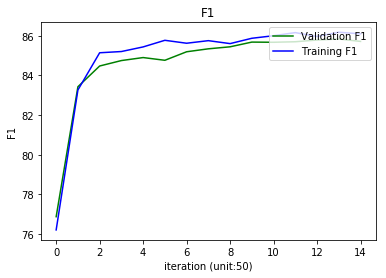

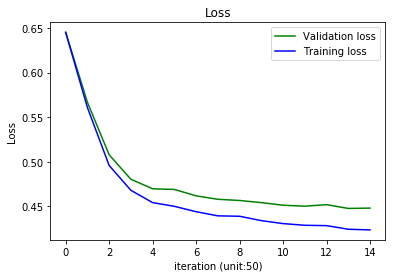

In [37]:
# embedded_train = [[embed_sequence(example[0], word2idx, glove_embeddings, elmos_train), example[2]]
#                       for example in raw_train[:10000]]
# train_dataset = TextDataset([example[0] for example in embedded_train],
#                                 [example[1] for example in embedded_train])
# train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,
#                                   collate_fn=TextDataset.collate_fn)

# embedded_train_small = [[embed_sequence(example[0], word2idx, glove_embeddings, elmos_train), example[2]]
#                       for example in raw_train[:1000]]
# train_dataset_small = TextDataset([example[0] for example in embedded_train_small],
#                                 [example[1] for example in embedded_train_small])
# train_dataloader_small = DataLoader(dataset=train_dataset_small, batch_size=batch_size, shuffle=True,
#                                   collate_fn=TextDataset.collate_fn)

# embedded_dev_small = [[embed_sequence(example[0], word2idx, glove_embeddings, elmos_dev), example[2]]
#                       for example in raw_dev[:500]]
# dev_dataset_small = TextDataset([example[0] for example in embedded_dev],
#                                 [example[1] for example in embedded_dev])
# dev_dataloader_small = DataLoader(dataset=dev_dataset, batch_size=batch_size, shuffle=True,
#                                   collate_fn=TextDataset.collate_fn)

using_GPU = False
"""
3. Model training
"""
'''
3. 1 
set up model, loss criterion, optimizer
'''
# Instantiate the model
# embedding_dim = glove + elmo + suffix indicator
# dropout1: dropout on input to RNN
# dropout2: dropout in RNN; would not be used if num_layers=1
# dropout3: dropout on hidden state of RNN to linear layer
# Separate the input (embedded_sequence) and labels in the indexed train sets.

# change embedding_dim=300+1024+50 if with elmo + suffix, 512 or 300 for hidden_size
rnn_clf = RNNSequenceClassifier(num_classes=2, embedding_dim=300+100, hidden_size=100, num_layers=1, bidir=True,
                                dropout1=0, dropout2=0, dropout3=0)
# Move the model to the GPU if available
if using_GPU:
    rnn_clf = rnn_clf.cuda()
# Set up criterion for calculating loss
nll_criterion = nn.NLLLoss()
# Set up an optimizer for updating the parameters of the rnn_clf
# rnn_clf_optimizer = optim.SGD(rnn_clf.parameters(), lr=0.01, momentum=0.9)
rnn_clf_optimizer = optim.Adam(rnn_clf.parameters(), lr=0.0001)
# Number of epochs (passes through the dataset) to train the model for.
num_epochs = 10

'''
3. 2
train model
'''
# without checkpoint, print during training
all_train_loss = [] 
# with checkpoints, print and plot at the end
training_loss = []
val_loss = []
training_f1 = []
val_f1 = []
# A counter for the number of gradient updates
num_iter = 0
for epoch in range(num_epochs):
    print("Starting epoch {}".format(epoch + 1))
    for (example_text, example_lengths, labels) in train_dataloader:
        example_text = Variable(example_text)
        example_lengths = Variable(example_lengths)
        labels = Variable(labels)
        if using_GPU:
            example_text = example_text.cuda()
            example_lengths = example_lengths.cuda()
            labels = labels.cuda()
        # predicted shape: (batch_size, 2)
        predicted = rnn_clf(example_text, example_lengths)
        batch_loss = nll_criterion(predicted, labels)
        rnn_clf_optimizer.zero_grad()
        batch_loss.backward()
        rnn_clf_optimizer.step()
        # keep record
        num_iter += 1
        all_train_loss.append(batch_loss.item())
        print('total loss: ', batch_loss.item())
        # Calculate validation and training set loss and accuracy every 200 gradient updates
        if num_iter % 50 == 0:
            avg_eval_loss, eval_accuracy, precision, recall, f1, fus_f1 = evaluate(dev_dataloader, rnn_clf,
                                                                                   nll_criterion, using_GPU)
            val_loss.append(avg_eval_loss)
            val_f1.append(f1)
            print(
                "Iteration {}. Validation Loss {}. Validation Accuracy {}. Validation Precision {}. Validation Recall {}. Validation F1 {}. Validation class-wise F1 {}.".format(
                    num_iter, avg_eval_loss, eval_accuracy, precision, recall, f1, fus_f1))
            # filename = '../models/LSTMSuffixElmoAtt_???_all_iter_' + str(num_iter) + '.pt'
            # torch.save(rnn_clf, filename)
            avg_eval_loss, eval_accuracy, precision, recall, f1, fus_f1 = evaluate(train_dataloader, rnn_clf,
                                                                                   nll_criterion, using_GPU)
            training_loss.append(avg_eval_loss)
            training_f1.append(f1)
            print(
                "Iteration {}. Training Loss {}. Training Accuracy {}. Training Precision {}. Training Recall {}. Training F1 {}. Training class-wise F1 {}.".format(
                    num_iter, avg_eval_loss, eval_accuracy, precision, recall, f1, fus_f1))
print("Training done!")

# cannot display the graph in terminal on remote server
"""
3.3
plot the training process: MET F1 and losses for validation and training dataset
"""
plt.figure(0)
plt.title('F1')
plt.xlabel('iteration (unit:50)')
plt.ylabel('F1')
plt.plot(val_f1,'g')
plt.plot(training_f1, 'b')
plt.legend(['Validation F1', 'Training F1'], loc='upper right')
plt.show()


plt.figure(1)
plt.title('Loss')
plt.xlabel('iteration (unit:50)')
plt.ylabel('Loss')
plt.plot(val_loss,'g')
plt.plot(training_loss, 'b')
plt.legend(['Validation loss', 'Training loss'], loc='upper right')
plt.show()


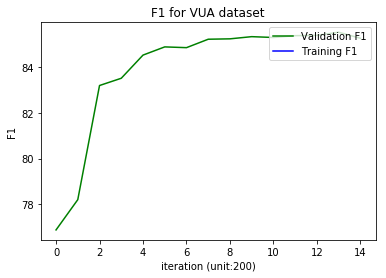

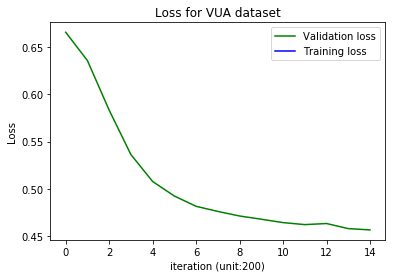

In [32]:
"""
3.3
plot the training process: MET F1 and losses for validation and training dataset
"""
plt.figure(0)
plt.title('F1 for VUA dataset')
plt.xlabel('iteration (unit:200)')
plt.ylabel('F1')
plt.plot(val_f1,'g')
plt.plot(training_f1, 'b')
plt.legend(['Validation F1', 'Training F1'], loc='upper right')
plt.show()


plt.figure(1)
plt.title('Loss for VUA dataset')
plt.xlabel('iteration (unit:200)')
plt.ylabel('Loss')
plt.plot(val_loss,'g')
plt.plot(training_loss, 'b')
plt.legend(['Validation loss', 'Training loss'], loc='upper right')
plt.show()

In [26]:
elmos_test = None
embedded_test =  [[embed_sequence(example[0], agg_words, word2idx, glove_embeddings, 
                                elmos_test, suffix_embeddings), example[2]]
                    for example in raw_test]
test_dataset = TextDataset([example[0] for example in embedded_test],
                                [example[1] for example in embedded_test])
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True,
                                  collate_fn=TextDataset.collate_fn)
avg_eval_loss, eval_accuracy, precision, recall, f1, fus_f1 = evaluate(test_dataloader, rnn_clf,
                                                                       nll_criterion, using_GPU)
# val_loss.append(avg_eval_loss)
# val_f1.append(f1)
print(
    "Iteration {}. Validation Loss {}. Validation Accuracy {}. Validation Precision {}. Validation Recall {}. Validation F1 {}. Validation class-wise F1 {}.".format(
        num_iter, avg_eval_loss, eval_accuracy, precision, recall, f1, fus_f1))

[[ 573.  110.]
 [ 337. 1429.]]
Iteration 1224. Validation Loss 0.4364060163497925. Validation Accuracy 81. Validation Precision 80.91732729331824. Validation Recall 92.85250162443145. Validation F1 86.47503782148262. Validation class-wise F1 79.20738708399932.


In [ ]:
Without suffix

[[ 574.  136.]
 [ 345. 1392.]]
Iteration 750. Validation Loss 0.4569096267223358. Validation Accuracy 80. Validation Precision 80.13816925734024. Validation Recall 91.09947643979058. Validation F1 85.26799387442573. Validation class-wise F1 77.87033825090224.